In [ ]:
import math
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from gan_synthesis.datasets.dataset import Dataset
from gan_synthesis.mask_vae_models.vae import VAE, dice_loss_mc_opts, kl_divergence_capacity

@dataclass
class TrainConfig:
    seed: int = 42
    epochs: int = 1000
    batch_size: int = 16
    lr: float = 1e-4
    weight_decay: float = 1e-4
    num_workers: int = 4
    pin_memory: bool = True
    amp: bool = False  
    ckpt_dir: str = "checkpoints"                                                                   
    val_split: float = 0.05
    latent_dim: int = 64
    lr_patience: int = 100  # ReduceLROnPlateau patience
    lr_factor: float = 0.5
    min_lr: float = 1e-5
    kl_scheduler: int = 700


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # comment out for speed if you don't need strict determinism
    # torch.use_deterministic_algorithms(True)
    # torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> float:
    """Pixel accuracy for segmentation."""
    pred = logits.argmax(dim=1)
    correct = (pred == targets).sum().item()
    total = targets.numel()
    return correct / total

def scheduler(epoch, target_epoch):
    return (epoch / target_epoch)

def build(cfg: TrainConfig):
    """Construct everything needed for training/eval, no side-effects."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Data ---
    dataset = Dataset()
    train_set, val_set = dataset.split(1 - cfg.val_split)

    common_loader_kwargs = dict(
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=cfg.pin_memory,
        persistent_workers=cfg.num_workers > 0,
    )
    train_loader = DataLoader(train_set, shuffle=True,  **common_loader_kwargs)
    val_loader   = DataLoader(val_set,   shuffle=False, **common_loader_kwargs)

    # --- Model / Loss / Optimizer / Scheduler / Scaler ---
    model = VAE(latent_dim=cfg.latent_dim).to(device)

    class_weights = getattr(dataset, "weights", None)
    if class_weights is not None:
        class_weights = class_weights.to(device=device, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=cfg.lr_factor,
        patience=cfg.lr_patience,
        min_lr=cfg.min_lr,
    )
    scaler = torch.amp.GradScaler("cuda") if (cfg.amp and device.type == "cuda") else None

    return {
        "device":       device,
        "model":        model,
        "criterion":    criterion,
        "optimizer":    optimizer,
        "scheduler":    scheduler,
        "scaler":       scaler,
        "train_set":    train_set,
        "val_set":      val_set,
        "train_loader": train_loader,
        "val_loader":   val_loader,
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scaler: torch.amp.GradScaler | None,
    device: torch.device,
    current_epoch: int,
    kl_schedule_epoch: int
) -> Dict[str, float]:
    model.train()
    running_loss = 0.0
    running_acc = 0.0    

    pbar = tqdm(loader, desc="Train", leave=False)
    for _, seg in pbar:
        seg_input = seg.to(torch.float32).to(device)
        seg_target = seg.squeeze(1).long().to(device)

        optimizer.zero_grad(set_to_none=True)

        if scaler is not None:
            with torch.amp.autocast(device_type=device.type, enabled=(scaler is not None)):
                recon, mu, logvar = model(seg_input)
                kld_loss = scheduler(current_epoch, kl_schedule_epoch) * kl_divergence_capacity(mu, logvar, epoch=current_epoch, beta=1, max_capacity=1)
                ce_loss = criterion(recon, seg_target)
                dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
                loss = dice_loss + kld_loss # + ce_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            recon, mu, logvar = model(seg_input)
            kld_loss = kl_divergence_capacity(mu, logvar, epoch=current_epoch, beta=1, max_capacity=50)
            ce_loss = criterion(recon, seg_target)
            dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=True)
            loss = dice_loss + kld_loss # + ce_loss
            loss.backward()
            optimizer.step()

        acc = accuracy_from_logits(recon.detach(), seg_target)
        running_loss += loss.item()
        running_acc += acc
        pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{acc:.4f}"})

    n = len(loader)
    return {"loss": running_loss / n, "acc": running_acc / n}


@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
    current_epoch: int,
) -> Dict[str, float]:
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    # inference_mode
    with torch.inference_mode():
        pbar = tqdm(loader, desc="Val", leave=False)
        for _, seg in pbar:
            seg_input = seg.to(torch.float32).to(device, non_blocking=True)
            seg_target = seg.squeeze(1).long().to(device, non_blocking=True)
            recon, mu, logvar = model(seg_input)

            kld_loss = kl_divergence_capacity(mu, logvar, epoch=current_epoch, beta=1, max_capacity=50)
            ce_loss = criterion(recon, seg_target)
            dice_loss = dice_loss_mc_opts(recon, seg_target, ignore_bg=False)
            loss = dice_loss + kld_loss # + ce_loss

            acc = accuracy_from_logits(recon, seg_target)

            running_loss += loss.item()
            running_acc += acc
            pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{acc:.4f}"})

    n = len(loader)
    return {"loss": running_loss / n, "acc": running_acc / n}


def main(cfg: TrainConfig) -> Tuple[nn.Module, Dict]:
    set_seed(cfg.seed)
    parts = build(cfg)

    device       = parts["device"]
    model        = parts["model"]
    criterion    = parts["criterion"]
    optimizer    = parts["optimizer"]
    scheduler    = parts["scheduler"]
    scaler       = parts["scaler"]
    train_loader = parts["train_loader"]
    val_loader   = parts["val_loader"]

    # --- Bookkeeping ---
    Path(cfg.ckpt_dir).mkdir(parents=True, exist_ok=True)
    best_val = math.inf
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    writer = SummaryWriter(log_dir=str(Path("runs") / "exp1"))  # <<< add

    for epoch in range(cfg.epochs):
        print(f"\nEpoch {epoch+1}/{cfg.epochs}")

        train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, current_epoch=epoch, kl_schedule_epoch=cfg.kl_scheduler)
        val_metrics   = evaluate(model, val_loader, criterion, device, current_epoch=epoch)

        scheduler.step(val_metrics["loss"])

        history["train_loss"].append(train_metrics["loss"])
        history["train_acc"].append(train_metrics["acc"])
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])

        # <<< add: TensorBoard scalars >>>
        writer.add_scalars("Loss", {"train": train_metrics["loss"],
                                    "val":   val_metrics["loss"]}, epoch)

        writer.add_scalars("Accuracy", {"train": train_metrics["acc"],
                                        "val":   val_metrics["acc"]}, epoch)
        writer.flush()

        print(
            f"train: loss {train_metrics['loss']:.4f} | acc {train_metrics['acc']:.4f} "
            f"|| val: loss {val_metrics['loss']:.4f} | acc {val_metrics['acc']:.4f} "
            f"|| lr: {optimizer.param_groups[0]['lr']:.2e}"
        )

        # Save latest
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scaler_state": scaler.state_dict() if scaler is not None else None,
                "cfg": cfg.__dict__,
                "history": history,
            },
            Path(cfg.ckpt_dir) / "latest.pt",
        )

        # Save best on val loss
        if val_metrics["loss"] < best_val:
            best_val = val_metrics["loss"]
            torch.save(model.state_dict(), Path(cfg.ckpt_dir) / "best_model.pt")

    print("\nTraining complete.")
    writer.close()
    return model, history  # <-- return the trained model too

   

if __name__ == "__main__":
    cfg = TrainConfig()
    model, history = main(cfg)



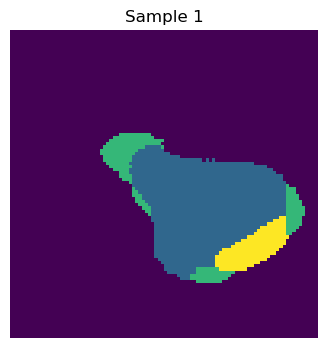

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')

In [121]:
import matplotlib.pyplot as plt
model.sample(1, mode="argmax")


In [47]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from gan_synthesis.preprocessing.transforms import read_cropped

def random_recon(model):
    num = randint(0, 368)
    image = read_cropped(idx=num, t="seg", as_type='pt').unsqueeze(0)
    seg_input = image.to(torch.float32).to("cuda")
    model.eval()
    with torch.no_grad():
        recon, mu, logvar = model(seg_input)
    
    recon = recon.argmax(dim=1)

    plt.imshow(image.squeeze().cpu().numpy())
    plt.show()
    plt.imshow(recon.squeeze().cpu().numpy())
    plt.show()
    

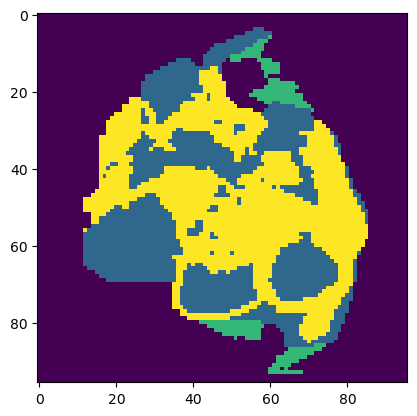

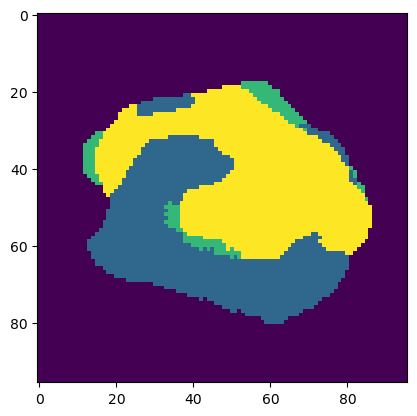

In [131]:
random_recon(model)